In [1]:
from argparse import Namespace


# model_name = 'tf_efficientnet_b4.ns_jft_in1k'
model_name='resnet50_gn.a1h_in1k'
args = Namespace(
  num_classes=200,
  in_channels=3,
  mid_channels=128,
  z_dim=128,
  num_ae_layers=0,
  num_protos = 600,
  freeze_body=True,
  # unfreeze_steps=[(10, '.')],
  unfreeze_steps_pretrained=[(0, '7.'), (2000, '.')],
  # unfreeze_steps=[(0, '.')],
  # unfreeze_steps=[(1000, '7.2'), (5000, '7.1'), (10000, '7.'), (15000, '.')],

  unfreeze_steps=[(1000, '7.2'), (4000, '7.1'), (9000, '7.')],
  batchsize=4,
  num_steps=10000,

  bias=False,

  kappa = 10,
  sharpen_pow = 2,
  bn_momentum = 1e-2,
  backbone_bn_momentum = 1e-2,

  model_name=model_name,

  # mask_threshold=0.1,
  # backbone_coef=1.0,
  last_layer_coef=1.0,
  # rec_coef=0.0,
  clus_coef=1.0,
  # unif_weight=0.1,
  # align_weight=1.0,
  contrastive_weight = 1.0,
  protos_probs_weight=0.5,
  # protos_sim_weight=0.1,
  l1_coef = 1.,


  prune_threshold=0.9,
  first_prune = 500,
  prune_every = 200,

  # lr=1e-4,
  lr_features=2.5e-05,
  lr_prototype_vectors=5e-04,
  lr_last_layers=2.5e-03,

  device='cuda',
  warmup_steps=20,
  val_batchsize=32,
  grad_accumulation_steps=4,
  num_steps_pretrained=10,
  num_epochs=200,
  checkpointing_steps=500,
  save_path=f'./working/protopnet_v1/cub2002011/{model_name}'
)

In [2]:
import os
import pandas as pd
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset


class Cub2011(Dataset):
    base_folder = 'CUB_200_2011/images'
    url = 'http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, train=True, transform=None, loader=default_loader, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])

        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, target


class ContrastiveDataset(Dataset):
  def __init__(self, root, transform1, transform2):
    self.dataset = Cub2011(root, True, None)
    self.transform1 = transform1
    self.transform2 = transform2


  def __getitem__(self, idx):
    img, target = self.dataset.__getitem__(idx)

    img = self.transform1(img)
    return self.transform2(img), self.transform2(img), target

  def __len__(self):
    return len(self.dataset)

In [3]:
import numpy as np
import argparse
import torch
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from typing import Tuple, Dict
from torch import Tensor
import random


IMAGE_SIZE = 288
# IMAGE_SIZE = 224

# function copied from https://pytorch.org/vision/stable/_modules/torchvision/transforms/autoaugment.html#TrivialAugmentWide (v0.12) and adapted
class TrivialAugmentWideNoColor(transforms.TrivialAugmentWide):
    def _augmentation_space(self, num_bins: int) -> Dict[str, Tuple[Tensor, bool]]:
        return {
            "Identity": (torch.tensor(0.0), False),
            "ShearX": (torch.linspace(0.0, 0.5, num_bins), True),
            "ShearY": (torch.linspace(0.0, 0.5, num_bins), True),
            "TranslateX": (torch.linspace(0.0, 16.0, num_bins), True),
            "TranslateY": (torch.linspace(0.0, 16.0, num_bins), True),
            "Rotate": (torch.linspace(0.0, 60.0, num_bins), True),
        }


import random

from PIL import ImageFilter

class GaussianBlur:
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[0.1, 2.0]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x


class TrivialAugmentWideNoShape(transforms.TrivialAugmentWide):
    def _augmentation_space(self, num_bins: int) -> Dict[str, Tuple[Tensor, bool]]:
        return {

            "Identity": (torch.tensor(0.0), False),
            "Brightness": (torch.linspace(0.0, 0.5, num_bins), True),
            "Color": (torch.linspace(0.0, 0.02, num_bins), True),
            "Contrast": (torch.linspace(0.0, 0.5, num_bins), True),
            "Sharpness": (torch.linspace(0.0, 0.5, num_bins), True),
            "Posterize": (8 - (torch.arange(num_bins) / ((num_bins - 1) / 6)).round().int(), False),
            "AutoContrast": (torch.tensor(0.0), False),
            "Equalize": (torch.tensor(0.0), False),
        }


shape = (3, IMAGE_SIZE, IMAGE_SIZE)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
normalize = transforms.Normalize(mean=mean,std=std)
transform_no_augment = transforms.Compose([
                        transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
                        transforms.ToTensor(),
                        normalize
                    ])
transform1p = None
transform1 = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE+8, IMAGE_SIZE+8)),
    TrivialAugmentWideNoColor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMAGE_SIZE+4, scale=(0.95, 1.))
])
transform1p = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE+32, IMAGE_SIZE+32)), #for pretraining, crop can be bigger since it doesn't matter when bird is not fully visible
    TrivialAugmentWideNoColor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMAGE_SIZE+4, scale=(0.95, 1.))
])
transform2 = transforms.Compose([
                    # TrivialAugmentWideNoShape(),

                    transforms.RandomApply(
                        [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8  # not strengthened
                    ),
                    transforms.RandomGrayscale(p=0.2),
                    transforms.RandomApply([GaussianBlur([0.1, 2.0])], p=0.5),


                    transforms.RandomCrop(size=(IMAGE_SIZE, IMAGE_SIZE)), #includes crop
                    transforms.ToTensor(),
                    normalize
                    ])

test_transform = transform_no_augment


In [4]:
from torch.utils.data import DataLoader

root = '../input/cub2002011'
trainds = ContrastiveDataset(root,
                             transform1=transform1, transform2=transform2)
contrastiveds = ContrastiveDataset(root,
                             transform1=transform1p, transform2=transform2)
valds = Cub2011(root,train=False, transform=test_transform)

train_loader = DataLoader(trainds, shuffle=True, batch_size=args.batchsize, drop_last=True)
contrastive_loader = DataLoader(contrastiveds, shuffle=True, batch_size=args.batchsize, drop_last=True)
val_loader = DataLoader(valds, batch_size=args.val_batchsize)

In [5]:
inspectds = iter(contrastiveds)

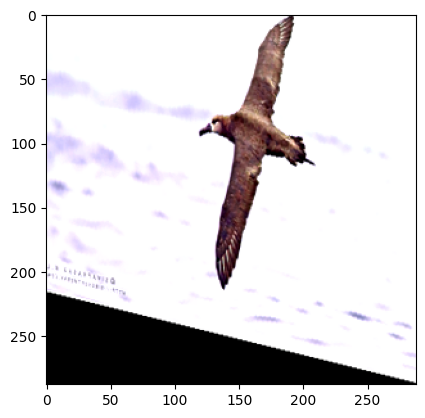

In [6]:
import matplotlib.pyplot as plt
from torchvision import transforms

im1, im2, lbl = next(inspectds)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])


plt.imshow(np.transpose(invTrans(im1), (1, 2, 0)))

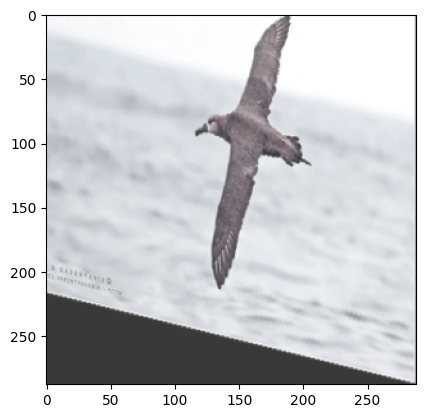

In [7]:
plt.imshow(np.transpose(invTrans(im2), (1, 2, 0)))

In [8]:
from timm import create_model
from fastai.vision.learner import _update_first_layer, has_pool_type, create_head, num_features_model
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.models.resnet import BasicBlock
from timm.layers.norm_act import BatchNormAct2d


def set_track_running_stats(module, track=True):
  if type(module).__name__.__contains__('BatchNorm'):
      module.track_running_stats = track
  for child in module.children():
    set_track_running_stats(child, track)


def set_bn_momentum(module, momentum=0.01):
  if type(module).__name__.__contains__('BatchNorm'):
      module.momentum = momentum
  for child in module.children():
    set_bn_momentum(child, momentum)


def set_training(module, train=True):
  module.train(train)
  set_track_running_stats(module, train)


def freeze_body(model, model_name='resnet50', params_to_train=None):
  if params_to_train is not None:
    for name,param in model.named_parameters():
      if any((param_name in name) for param_name in params_to_train):
        param.requires_grad=True
      else:
        param.requires_grad=False
    return
  if 'resnet50' in model_name:
    freeze_body(model, model_name, params_to_train=['7.0', '7.1', '7.2'])


def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NameError("cut must be either integer or function")


# adapted from https://github.com/yumeng5/TopClus/blob/main/src/trainer.py
def target_distribution(probs, p=2):
    targets = (probs ** p) / probs.sum(dim=1, keepdim=True)  # shape: (B, N, K)
    targets = (targets / targets.sum(dim=2, keepdim=True))
    return targets



# adapted from https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear
class NonNegLinear(nn.Module):
    """Applies a linear transformation to the incoming data with non-negative weights`
    """
    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(NonNegLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(1e-1 * torch.randn((out_features, in_features), **factory_kwargs))
        self.normalization_multiplier = nn.Parameter(torch.ones((1,),requires_grad=True))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input,torch.relu(self.weight), self.bias)

class MyModel(nn.Module):
  def __init__(self, args):
    super(MyModel, self).__init__()

    self.args = args

    self.z_dim = args.z_dim
    mid_channels = args.mid_channels
    self.kappa = args.kappa
    self.num_protos = args.num_protos

    self.backbone = create_timm_body(args.model_name, pretrained=True, n_in=args.in_channels)

    self.nf = num_features_model(self.backbone)

    norm_layer = nn.Identity
    num_ae_layers = args.num_ae_layers
    self.z_encoder = nn.Sequential(
      nn.Conv2d(self.nf       , self.z_dim * 1, kernel_size=1, stride=1, padding=0),
    )
    # self.z_decoder = nn.Sequential(
    #   nn.Conv2d(self.z_dim * 1, self.nf       , kernel_size=1, stride=1, padding=0),
    # )


    self.pool_layer = nn.Sequential(
      nn.AdaptiveMaxPool2d(output_size=(1,1)), #outputs (bs, ps,1,1)
      nn.Flatten() #outputs (bs, ps)
    )

    self.prototype_vectors = nn.Parameter(torch.rand(self.num_protos, self.z_dim), requires_grad=True)

    # self.classification_head = create_head(self.nf, args.num_classes, pool=False)
    self.protos_classifier = NonNegLinear(self.num_protos, args.num_classes, bias=args.bias)
    self.protos_mask = nn.Parameter(torch.ones(self.num_protos), requires_grad=False)


  def get_protos_sim(self, z, mask_value=-1.0):
    z = F.normalize(z, dim=1)
    self.prototype_vectors.data = F.normalize(self.prototype_vectors.data, dim=1)
    sim = torch.einsum('bdhw,dk->bkhw', z, self.prototype_vectors.t())
    protos_mask = self.protos_mask.view(1, self.num_protos, 1, 1).expand_as(sim)
    return sim.where(protos_mask == 1.0, mask_value)

  def get_protos_probs(self, z):
    sim = self.get_protos_sim(z)
    probs = F.softmax(sim * self.kappa, dim=1)
    return probs

  def get_protos_probs_patches(self, x):
    b = x.shape[0]
    nf = self.nf
    z_dim = self.z_dim
    num_protos = self.num_protos

    h_patches = self.backbone(x)
    z_patches = self.z_encoder(h_patches)

    protos_probs_patches = self.get_protos_probs(z_patches) # (b, num_protos, h, w)
    return protos_probs_patches

  def get_protos_probs_images(self, x):
    b = x.shape[0]
    nf = self.nf
    z_dim = self.z_dim
    num_protos = self.num_protos

    h_patches = self.backbone(x)
    h_image = h_patches.mean(dim=[2, 3]) # (b, nf)
    z_image = self.z_encoder(h_image.view(b, nf, 1, 1)) # (b, z_dim, 1, 1)
    protos_probs = self.get_protos_probs(z_image).view(b, -1) # (b, num_protos)
    return protos_probs


  def get_protos_sim_patches(self, x):
    b = x.shape[0]
    nf = self.nf
    z_dim = self.z_dim
    num_protos = self.num_protos

    h_patches = self.backbone(x)
    z_patches = self.z_encoder(h_patches)

    protos_sim_patches = self.get_protos_sim(z_patches) # (b, num_protos, h, w)
    return protos_sim_patches

  def get_protos_sim_images(self, x):
    b = x.shape[0]
    nf = self.nf
    z_dim = self.z_dim
    num_protos = self.num_protos

    h_patches = self.backbone(x)
    h_image = h_patches.mean(dim=[2, 3]) # (b, nf)
    z_image = self.z_encoder(h_image.view(b, nf, 1, 1)) # (b, z_dim, 1, 1)
    protos_sim_images = self.get_protos_sim(z_image).view(b, -1) # (b, num_protos)
    return protos_sim_images


  def fix_linear_weights(self):
    pass

  def prune_protos(self, threshold=0.0):
    pass


  def forward(self, x, lbl=None, calc_contrastive_loss=False, calc_classification_loss=False,):
    if len(x.shape) == 3: x = x[None]
    b = x.shape[0]
    nf = self.nf
    z_dim = self.z_dim
    num_protos = self.num_protos

    h_patches = self.backbone(x)
    z_patches = self.z_encoder(h_patches)


    # debug_val =(z_patches.detach().max()).item()
    # if debug_val > 500:
    #   print('warning, weights are too big', debug_val)

    protos_sim_patches = self.get_protos_sim(z_patches)
    protos_probs_patches = F.softmax(protos_sim_patches * self.kappa, dim=1)

    protos_sim = self.pool_layer(protos_sim_patches)
    # protos_mask = self.protos_mask.view(1, self.num_protos).expand_as(protos_sim)
    # protos_sim = protos_sim.where(protos_mask == 1.0, -1.0)

    logits = None

    inference = (not calc_contrastive_loss) and (not calc_classification_loss)
    if inference:
      logits = self.protos_classifier(F.relu(protos_sim))
      return logits

    if calc_classification_loss:
      logits = self.protos_classifier(F.relu(protos_sim))
      classification_loss = (
        self.args.last_layer_coef * (
          F.cross_entropy(logits, lbl)
        )
      )
      ret_classification_loss = (
        classification_loss.detach() / self.args.last_layer_coef
      )

      linear_weights = torch.cat([F.relu(x).view(-1) for x in [self.protos_classifier.weight]])
      l1_reg = self.args.l1_coef * torch.norm(linear_weights, 1) / linear_weights.shape[0]
    else:
      classification_loss = torch.tensor(0.0, device=x.device)
      ret_classification_loss = torch.tensor(0.0, device=x.device)
      l1_reg = torch.tensor(0.0, device=x.device)


    if calc_contrastive_loss:
      clus_weight = args.clus_coef
      ### NT_Xent loss
      temperature = 1.
      # [B, D, H, W]
      z_patches1, z_patches2 = z_patches.chunk(2)
      out_1 = F.normalize(z_patches1,dim=1).flatten(start_dim=2).permute(0,2,1).flatten(end_dim=1)
      out_2 = F.normalize(z_patches2,dim=1).flatten(start_dim=2).permute(0,2,1).flatten(end_dim=1)
      curr_b = out_1.shape[0]
      # [2*B, D]
      out = torch.cat([out_1, out_2], dim=0)
      # [2*B, 2*B]
      sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
      mask = (torch.ones_like(sim_matrix) - torch.eye(2 * curr_b, device=sim_matrix.device)).bool()
      # [2*B, 2*B-1]
      sim_matrix = sim_matrix.masked_select(mask).view(2 * curr_b, -1)

      # compute loss
      pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
      # [2*B]
      pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
      contrastive_loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()


      ### sharpen the prototypes distribution
      protos_probs_weight = self.args.protos_probs_weight
      contrastive_weight = self.args.contrastive_weight
      b, k, h, w = protos_probs_patches.shape
      preds = protos_probs_patches.view(b, k, -1).transpose(1, 2) + 1e-6 # (b, h*w, k)
      preds /= preds.sum(dim=2, keepdim=True)
      targets = target_distribution(preds.detach(), self.args.sharpen_pow).detach()
      # if ((targets - preds).sum().item() == 0.0):
      #   print(F.cross_entropy(preds.log(), targets).item(), targets)
      # protos_probs_loss = F.kl_div(preds.log().reshape(-1, k), targets.reshape(-1, k), reduction='batchmean')
      protos_probs_loss = F.cross_entropy(preds.log().reshape(-1, k), targets.reshape(-1, k).detach())
      clustering_loss = clus_weight * (contrastive_weight * contrastive_loss + protos_probs_weight * protos_probs_loss)


      # contrastive_loss = torch.tensor(0.0, device=x.device)
      # protos_probs_loss = torch.tensor(0.0, device=x.device)
      # clustering_loss = torch.tensor(0.0, device=x.device)
    else:
      contrastive_loss = torch.tensor(0.0, device=x.device)
      protos_probs_loss = torch.tensor(0.0, device=x.device)
      clustering_loss = torch.tensor(0.0, device=x.device)


    # Total loss
    total_loss = classification_loss + clustering_loss + l1_reg

    if torch.isnan(total_loss):
      print((classification_loss, (classification_loss, contrastive_loss, protos_probs_loss), l1_reg))
      assert False

    return logits, (total_loss, ret_classification_loss, contrastive_loss, protos_probs_loss, l1_reg)

def uniform_loss(x, t=2):
    # print("sum elements: ", torch.sum(torch.pow(x,2), dim=1).shape, torch.sum(torch.pow(x,2), dim=1)) #--> should be ones
    loss = (torch.pdist(x, p=2).pow(2).mul(-t).exp().mean() + 1e-10).log()
    return loss

# adapted from https://gitlab.com/mipl/carl/-/blob/main/losses.py
def align_loss(inputs, targets, alpha=2, EPS=1e-12):
    assert inputs.shape == targets.shape
    assert targets.requires_grad == False

    loss = (inputs - targets).norm(p=2, dim=1).pow(alpha).mean()
    return loss

def NT_Xent(xs, temperature=1.,):
  batch_size = args.batchsize

  # xs [2*B, D]
  x1, x2 = xs[:batch_size], xs[batch_size:]
  # [2*B, 2*B]
  sim_matrix = torch.exp(torch.mm(xs, xs.t().contiguous()) / temperature)
  mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=sim_matrix.device)).bool()
  # [2*B, 2*B-1]
  sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)

  # compute loss
  pos_sim = torch.exp(torch.sum(x1 * x2, dim=-1) / temperature)
  # [2*B]
  pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
  loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()

  return loss

In [9]:
model = MyModel(args)

In [ ]:
set_bn_momentum(model, args.bn_momentum)
set_bn_momentum(model.backbone, args.backbone_bn_momentum)

In [ ]:
import numpy as np
def pytorch_count_params(model):
  "count number trainable parameters in a pytorch model"
  total  = sum(p.numel() for p in model.parameters())
  trainable  = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total, trainable

total, trainable = pytorch_count_params(model.backbone)
print(f"Total: {total/1e6:.4f}M, Trainable: {trainable/1e6:.4f}M")
def get_model_size(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    model_size = sum([np.prod(p.size()) for p in model_parameters])
    return "{}M".format(round(model_size / 1e+3) / 1e3)

get_model_size(model.backbone), get_model_size(model.z_encoder), get_model_size(model.protos_classifier)

Total: 23.5080M, Trainable: 23.5080M


('23.508M', '0.262M', '0.12M')

In [ ]:
from torch.optim import AdamW, SGD
from lion_pytorch import Lion
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

features = [model.backbone]
add_on_layers = [model.z_encoder]
last_layers = [model.protos_classifier]
sqrt_batchsize = args.batchsize ** 0.5
params = [
  *[{'params': module.parameters(), 'lr': args.lr_features      * sqrt_batchsize, 'weight_decay': 1e-2} for module in features],
  *[{'params': module.parameters(), 'lr': args.lr_features * 10 * sqrt_batchsize, 'weight_decay': 1e-2} for module in add_on_layers],
  *[{'params': module.parameters(), 'lr': args.lr_last_layers   * sqrt_batchsize, 'weight_decay': 1e-2} for module in last_layers],
  *[{'params': model.prototype_vectors, 'lr': args.lr_prototype_vectors * sqrt_batchsize, 'weight_decay': 1e-2}],
]

# opt = Lion(params)
opt = AdamW(params)
# opt = SGD(params)

num_steps = min(args.num_epochs * len(train_loader), args.num_steps)
warmup = LinearLR(opt, start_factor=1/args.warmup_steps, total_iters=args.warmup_steps)
reduce = CosineAnnealingLR(opt, T_max=num_steps)
scheduler = SequentialLR(opt, [warmup, reduce], milestones=[args.warmup_steps])

In [ ]:
import torch
import os


def save_model(step, best_score):
  # save_dir = os.path.join(args.save_path, 'ckpt%d'%step)
  os.makedirs(args.save_path, exist_ok=True)
  # torch.save((best_score, model.state_dict()), os.path.join(save_dir, 'pytorch_model.bin'))
  torch.save((best_score, model.state_dict()), os.path.join(args.save_path, 'pytorch_model.bin'))

def load_model(prev_score):
  if os.path.isfile(os.path.join(args.save_path, 'pytorch_model.bin')):
    best_score, state_dict = torch.load(os.path.join(args.save_path, 'pytorch_model.bin'))
    if best_score > prev_score:
      model.load_state_dict(state_dict)
      print('loaded')
      prev_score = best_score
  return prev_score

In [ ]:
from sklearn.metrics import top_k_accuracy_score
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

def eval():
  pbar = tqdm(val_loader, position=0, leave=True)
  model.to(args.device)
  set_training(model, False)
  y_pred = []
  y_true = []
  with torch.no_grad():
    for sample in pbar:
      image, label = sample
      image = image.to(args.device)
      label = label.to(args.device)
      out, all_losses = model.forward(image, label, calc_classification_loss=True)
      out = F.softmax(out, dim=1)

      y_pred += [out.detach().cpu().numpy()]
      y_true += [label.cpu().numpy()]
      pbar.set_description('acc=%.4f' % (
        top_k_accuracy_score(np.concatenate(y_true, axis=0), np.concatenate(y_pred, axis=0), k=1, labels=range(args.num_classes)),
      ))

  y_true = np.concatenate(y_true, axis=0)
  y_pred = np.concatenate(y_pred, axis=0)
  return (top_k_accuracy_score(y_true, y_pred, k=1, labels=range(args.num_classes)),
        top_k_accuracy_score(y_true, y_pred, k=5, labels=range(args.num_classes)))


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:

set_training(model, False)
model.cuda()
xs1, xs2, ys = next(iter(train_loader))
xs, ys = torch.cat([xs1,xs2]), torch.cat([ys,ys])
x = xs.cuda()
y = ys.cuda()
with torch.no_grad():
  logits, losses = model(x, y, True, True)
[l.item() for l in losses]

[17.0026912689209,
 5.339709758758545,
 8.55279541015625,
 6.140769958496094,
 0.03980148956179619]

In [ ]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print (name, param.grad)

In [ ]:
torch.cuda.empty_cache()

from sklearn.metrics import top_k_accuracy_score, accuracy_score
from copy import deepcopy

freeze_body(model.backbone, params_to_train=[p[1] for p in args.unfreeze_steps])
model.to(args.device)
step = 0
best_score = 0.0

best_score = load_model(best_score)


contrastive_iter = iter(contrastive_loader)
def next_contrastive_sample():
  try: return next(contrastive_iter)
  except:
    contrastive_iter = iter(contrastive_loader)
    return next(contrastive_iter)



# for epoch in range(1, 4):
for epoch in range(1, 2):
  pbar = tqdm(train_loader, position=0, leave=True)
  for sample in pbar:
    step += 1
    if step > 20: break
    set_training(model, True)



    opt.zero_grad()
    xs1, xs2, ys = next_contrastive_sample()
    xs = torch.cat([xs1, xs2]).cuda()
    ys = torch.cat([ys, ys]).cuda()
    (logits, all_losses) = model.forward(xs, ys, calc_classification_loss=True, calc_contrastive_loss=True)
    loss = all_losses[0]
    loss.backward()

    grad = torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    opt.step()
    scheduler.step()
    opt.zero_grad()

    del xs1, xs2, ys


    xs1, xs2, ys = sample
    xs = torch.cat([xs1, xs2]).cuda()
    ys = torch.cat([ys, ys]).cuda()
    (logits, all_losses) = model.forward(xs, ys, calc_classification_loss=True, calc_contrastive_loss=True)
    plt_losses = all_losses
    loss = all_losses[0] * 1e-6
    loss.backward()

    grad = torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    opt.step()
    scheduler.step()
    model.fix_linear_weights()
    opt.zero_grad()

    del xs1, xs2, ys


  8%|▊         | 9/115 [00:41<08:11,  4.64s/it]/media/minhduck/SSD1/Documents/projects/pyenvs/rlhf/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 17%|█▋        | 20/115 [01:32<07:17,  4.60s/it]


In [ ]:
# from sklearn.metrics import top_k_accuracy_score, accuracy_score
# from copy import deepcopy
# model.args.last_layer_coef = 0.0

# plot = True
# plot_every = 20
# prune_every = int(args.first_prune)
# next_prune = prune_every
# unfreeze_steps = deepcopy(getattr(args, 'unfreeze_steps_pretrained', []))
# unfreeze_params = []

# losses = []
# losses_rec = []
# accs = []
# grads = []
# model.to(args.device)
# step = 0
# best_score = 0.0

# best_score = load_model(best_score)

# model.protos_classifier.weight.requires_grad = False
# if len(unfreeze_steps):
#   freeze_body(model.encoder, params_to_train=unfreeze_params)

# contrastive_iter = iter(contrastive_loader)
# def next_contrastive_sample():
#   try: return next(contrastive_iter)
#   except:
#     contrastive_iter = iter(contrastive_loader)
#     return next(contrastive_iter)



# # for epoch in range(1, 4):
# for epoch in range(1, args.num_epochs + 1):
#   pbar = tqdm(train_loader, position=0, leave=True)
#   for sample in pbar:
#     step += 1
#     if step > args.num_steps_pretrained: break
#     set_training(model, True)



#     opt.zero_grad()
#     xs1, xs2, ys = next_contrastive_sample()
#     xs = torch.cat([xs1, xs2]).cuda()
#     ys = torch.cat([ys, ys]).cuda()
#     (logits, all_losses) = model.forward(xs, ys, calc_classification_loss=False, calc_contrastive_loss=True)
#     loss = all_losses[0]
#     loss.backward()

#     grad = torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
#     opt.step()
#     scheduler.step()
#     model.fix_linear_weights()
#     opt.zero_grad()
#     losses += [loss.cpu().detach().item()]
#     losses_rec += [[l.detach().item() for l in all_losses]]
#     grads += [grad.cpu().detach().item()]

#     # losses_rec += [[l.detach().item() for l in all_losses]]

#     del xs1, xs2, ys


#     xs1, xs2, ys = sample
#     xs = torch.cat([xs1, xs2]).cuda()
#     ys = torch.cat([ys, ys]).cuda()
#     (logits, all_losses) = model.forward(xs, ys, calc_classification_loss=False, calc_contrastive_loss=True)
#     plt_losses = all_losses
#     loss = all_losses[0]
#     loss.backward()

#     grad = torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
#     opt.step()
#     scheduler.step()
#     model.fix_linear_weights()
#     opt.zero_grad()
#     # acc = accuracy_score(ys.detach().cpu().numpy(),
#     #                      out.detach().cpu().argmax(dim=1).numpy())
#     # accs += [acc]
#     if logits is not None:
#       accs += [top_k_accuracy_score(
#         ys.detach().cpu().numpy(), logits.detach().cpu().numpy(),
#         k=1, labels=range(args.num_classes))]


#     if plot and step % plot_every == 0:
#       clear_output(True)
#       fig, axes = plt.subplots(1, 1, figsize=(5,5))
#       axes.plot([l[2] for l in losses_rec])
#       plt.show()
#       print(losses_rec[-1])
#       with torch.no_grad(): protos_sim_patches = model.get_protos_sim_patches(x=xs[:3])
#       # with torch.no_grad(): protos_probs_patches = model.get_protos_probs_patches(x=xs[:3])
#       # print(protos_sim_patches[0, :].argmax(dim=0).detach().cpu().numpy())
#       # print(protos_sim_patches[1, :].argmax(dim=0).detach().cpu().numpy())
#       # print(protos_sim_patches[0, :].max(dim=0).values.detach().cpu().numpy())
#       sim_stats = (protos_sim_patches[0, :].max(dim=0).values.detach().cpu().numpy())
#       # probs_stats = (protos_probs_patches[0, :].max(dim=0).values.detach().cpu().numpy())

#       total, trainable = pytorch_count_params(model.encoder)
#       print("Pretraining")
#       print(f"Total: {get_model_size(model)}, Backbone: {total/1e6:.4f}M, Trainable: {trainable/1e6:.4f}M")
#       print('sim stats:', sim_stats.max(), 'max ;', sim_stats.mean(), "±", sim_stats.std(), ';', sim_stats.min(), 'min')
#       # print(1-protos_sim_patches.max(dim=1).values[0].mean().item())
#       # print(1-protos_sim_patches.max(dim=1).values.mean().item())
#       # print('probs stats:', probs_stats.max(), 'max,', probs_stats.mean(), "±", probs_stats.std())
#       print('num active protos:', model.protos_mask.sum().item())


#     if len(unfreeze_steps):
#       next_freeze_step, unfreeze_param = unfreeze_steps[0]
#       if step >= next_freeze_step:
#         unfreeze_steps.pop(0)
#         unfreeze_params.append(unfreeze_param)
#         freeze_body(model.encoder, params_to_train=unfreeze_params)
#         total, trainable = pytorch_count_params(model.encoder)
#         print(f"Unfreezed => Total: {get_model_size(model)}, Backbone: {total/1e6:.4f}M, Trainable: {trainable/1e6:.4f}M")

#     if step == next_prune:
#       model.prune_protos(args.prune_threshold)
#       prune_every = int(0.25 * prune_every + 0.75 * args.prune_every)
#       next_prune = prune_every + step

#     pbar.set_description_str('Ep %d, step %d, best=%.4f: loss=%.4f, grad=%.4f, top1=%.4f, lr=%.4e' % (
#       epoch, step, best_score,
#       np.mean(losses[-128:]), np.mean(grads[-128:]), 0.0 if not len(accs) else np.mean(accs[-128:]), scheduler.get_last_lr()[-1]))
#     # if step % args.checkpointing_steps == 0:
#     #   top1, top5 = eval()
#     #   print("Top1: %.4f, Top5: %.4f" % (top1, top5))
#     #   if top1 > best_score:
#     #     save_model(step, top1)
#     #     best_score = top1
#     #     print('New best: %.4f' % top1)
#     del xs, xs1, xs2, ys, all_losses

#   # ### End epoch
#   # top1, top5 = eval(classifier_idx)
#   # print("Top1: %.4f, Top5: %.4f" % (top1, top5))
#   # if top1 > best_score:
#   #   save_model(step, top1)
#   #   best_score = top1
#   #   print('New best: %.4f' % top1)


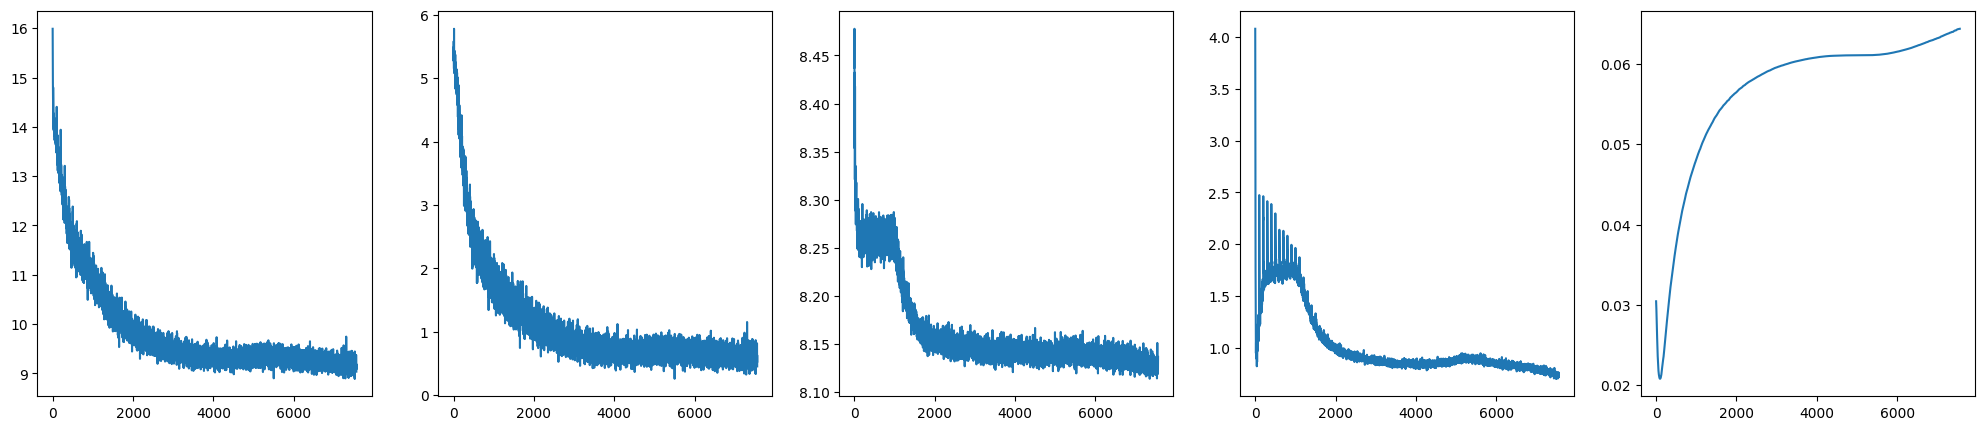

Ep 66, step 7560, best=0.7710: loss=9.1654, grad=2.4349, top1=0.8508, lr=1.8820e-03:  74%|███████▍  | 85/115 [07:59<02:29,  4.98s/it]

[9.03394603729248, 0.45470476150512695, 8.13644790649414, 0.7568477988243103, 0.06437008082866669]
Total: 9.384M, Backbone: 23.5080M, Trainable: 8.9252M
sim stats: 0.9884571 max ; 0.8576069 ± 0.11258364 ; 0.49935338 min
num active protos: 600.0


Ep 66, step 7571, best=0.7710: loss=9.1650, grad=2.4402, top1=0.8501, lr=1.8945e-03:  83%|████████▎ | 96/115 [08:53<01:45,  5.56s/it]


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

from sklearn.metrics import top_k_accuracy_score, accuracy_score
from copy import deepcopy
model.args = args


randomize_protos_step = 100
noise_magnitude = 1.
noise_decay=0.9


plot = True
plot_every = 20
prune_every = int(args.first_prune)
next_prune = prune_every
unfreeze_steps = deepcopy(getattr(args, 'unfreeze_steps', []))
unfreeze_params = []

losses = []
losses_rec = []
accs = []
grads = []
model.to(args.device)
step = 0
best_score = 0.0

best_score = load_model(best_score)

model.protos_classifier.weight.requires_grad = True
if len(unfreeze_steps):
  freeze_body(model.backbone, params_to_train=unfreeze_params)

contrastive_iter = iter(contrastive_loader)
def next_contrastive_sample():
  try: return next(contrastive_iter)
  except:
    contrastive_iter = iter(contrastive_loader)
    return next(contrastive_iter)



# for epoch in range(1, 4):
for epoch in range(1, args.num_epochs + 1):
  pbar = tqdm(train_loader, position=0, leave=True)
  for sample in pbar:
    step += 1
    if step > args.num_steps: break
    set_training(model, True)


    opt.zero_grad()
    xs1, xs2, ys = next_contrastive_sample()
    xs = torch.autograd.Variable(torch.cat([xs1, xs2]).cuda())
    ys = torch.autograd.Variable(torch.cat([ys, ys]).cuda())
    (logits, all_losses) = model.forward(xs, ys, calc_classification_loss=False, calc_contrastive_loss=True)
    loss = all_losses[0]
    loss.backward()
    grad = torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    opt.step()
    # scheduler.step()
    # model.fix_linear_weights()
    opt.zero_grad()

    # losses_rec += [[l.detach().item() for l in all_losses]]

    del xs1, xs2, ys

    xs1, xs2, ys = sample
    xs = torch.autograd.Variable(torch.cat([xs1, xs2]).cuda())
    ys = torch.autograd.Variable(torch.cat([ys, ys]).cuda())
    (logits, all_losses) = model.forward(xs, ys, calc_classification_loss=True, calc_contrastive_loss=True)
    plt_losses = all_losses
    loss = all_losses[0]
    loss.backward()

    grad = torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    opt.step()
    scheduler.step()
    # model.fix_linear_weights()
    opt.zero_grad()

    losses += [loss.cpu().detach().item()]
    losses_rec += [[l.detach().item() for l in all_losses]]
    grads += [grad.cpu().detach().item()]
    # acc = accuracy_score(ys.detach().cpu().numpy(),
    #                      out.detach().cpu().argmax(dim=1).numpy())
    # accs += [acc]
    accs += [top_k_accuracy_score(
      ys.detach().cpu().numpy(), logits.detach().cpu().numpy(),
      k=1, labels=range(args.num_classes))]


    if plot and step % plot_every == 0:
      clear_output(True)
      num_axes = len(losses_rec[0])
      fig, axes = plt.subplots(1, num_axes, figsize=(5 * num_axes, 5))
      for i in range(num_axes):
        axes[i].plot([l[i] for l in losses_rec])
      plt.show()
      print(losses_rec[-1])
      with torch.no_grad(): protos_sim_patches = model.get_protos_sim_patches(x=xs[:3])
      with torch.no_grad(): protos_probs_patches = model.get_protos_probs_patches(x=xs[:3])
      # print(protos_sim_patches[0, :].argmax(dim=0).detach().cpu().numpy())
      # print(protos_sim_patches[1, :].argmax(dim=0).detach().cpu().numpy())
      # print(protos_sim_patches[0, :].max(dim=0).values.detach().cpu().numpy())
      sim_stats = (protos_sim_patches[0, :].max(dim=0).values.detach().cpu().numpy())
      probs_stats = (protos_probs_patches[0, :].max(dim=0).values.detach().cpu().numpy())

      total, trainable = pytorch_count_params(model.backbone)
      print(f"Total: {get_model_size(model)}, Backbone: {total/1e6:.4f}M, Trainable: {trainable/1e6:.4f}M")
      print('sim stats:', sim_stats.max(), 'max ;', sim_stats.mean(), "±", sim_stats.std(), ';', sim_stats.min(), 'min')
      # print(1-protos_sim_patches.max(dim=1).values[0].mean().item())
      # print(1-protos_sim_patches.max(dim=1).values.mean().item())
      # print('probs stats:', probs_stats.max(), 'max,', probs_stats.mean(), "±", probs_stats.std())
      print('num active protos:', model.protos_mask.sum().item())


    if len(unfreeze_steps):
      next_freeze_step, unfreeze_param = unfreeze_steps[0]
      if step >= next_freeze_step:
        unfreeze_steps.pop(0)
        unfreeze_params.append(unfreeze_param)
        freeze_body(model.backbone, params_to_train=unfreeze_params)
        total, trainable = pytorch_count_params(model.backbone)
        print(f"Unfreezed => Total: {get_model_size(model)}, Backbone: {total/1e6:.4f}M, Trainable: {trainable/1e6:.4f}M")

    if step % randomize_protos_step == 0:
      noise = torch.randn(model.prototype_vectors.shape, device=model.prototype_vectors.device)
      noise = F.normalize(noise, dim=1)
      model.prototype_vectors.data += noise * noise_magnitude
      noise_magnitude = 0.01 + noise_magnitude * noise_decay
    # if step == next_prune:
    #   model.prune_protos(args.prune_threshold)
    #   prune_every = int(0.25 * prune_every + 0.75 * args.prune_every)
    #   next_prune = prune_every + step

    pbar.set_description_str('Ep %d, step %d, best=%.4f: loss=%.4f, grad=%.4f, top1=%.4f, lr=%.4e' % (
      epoch, step, best_score,
      np.mean(losses[-128:]), np.mean(grads[-128:]), np.mean(accs[-128:]), scheduler.get_last_lr()[-1]))
    if step % args.checkpointing_steps == 0:
      top1, top5 = eval()
      print("Top1: %.4f, Top5: %.4f" % (top1, top5))
      if top1 > best_score:
        save_model(step, top1)
        best_score = top1
        print('New best: %.4f' % top1)
    del xs, xs1, xs2, ys, all_losses

  # ### End epoch
  # top1, top5 = eval(classifier_idx)
  # print("Top1: %.4f, Top5: %.4f" % (top1, top5))
  # if top1 > best_score:
  #   save_model(step, top1)
  #   best_score = top1
  #   print('New best: %.4f' % top1)


In [ ]:
best_score = load_model(0.0)
print('best_score =',best_score)
# for _ in range(10):
#   model.prune_protos(0.9)

loaded
best_score = 0.7709699689333793


/tmp/ipykernel_239147/54921099.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_score, state_dict = torch.load(os.path.join(args.save_path, 'pytorch_model.bin'))


In [ ]:
eval()

acc=0.7710: 100%|██████████| 91/91 [01:22<00:00,  1.11it/s]


(0.7709699689333793, 0.9461511908871246)

In [ ]:
idx = 12
x, y = list(iter(val_loader))[idx]
x, y = x[:1], y[:1]

model.eval().cpu()
with torch.no_grad():
  out = model(x, None, False, False)

In [ ]:
y_pred = out[0].argmax()
y[0], y_pred

(tensor(28), tensor(28))

In [ ]:
with torch.no_grad():
  pp = model.get_protos_probs_patches(x=x)
  ps = model.get_protos_sim_patches(x=x)
  pset = set()
  for bi in range(len(pp)):
    pset.add(tuple(pid for pid in range(args.num_protos) if pp[bi,pid].max() > 0.5))

In [ ]:
with torch.no_grad():
  protos_sim = F.max_pool2d(ps, kernel_size=ps.shape[2:]).view(ps.shape[0], -1) # (b, num_protos)

sorted_sim, indices = protos_sim[0].sort(descending=True)
[(sorted_sim[i], indices[i]) for i in range(10)]

[(tensor(0.9644), tensor(250)),
 (tensor(0.9589), tensor(232)),
 (tensor(0.9561), tensor(321)),
 (tensor(0.9553), tensor(84)),
 (tensor(0.9460), tensor(532)),
 (tensor(0.9410), tensor(575)),
 (tensor(0.9407), tensor(115)),
 (tensor(0.9348), tensor(4)),
 (tensor(0.9335), tensor(280)),
 (tensor(0.9313), tensor(284))]

In [ ]:
logits = out
log_prob, c_pred = logits[0,].max(dim=0)
log_prob, c_pred

(tensor(14.9643), tensor(28))

In [ ]:
lin_weight = list(model.protos_classifier.parameters())
len(lin_weight)
W, b = model.protos_classifier.weight, list(lin_weight)[1]
W, b = W.detach().cpu(), b.detach().cpu()

if not args.bias:
  print((b[0] + torch.sum(W[c_pred, :] * protos_sim[0])), log_prob)

  protos_score = W[c_pred, :] * protos_sim[0]
  sorted_scores, indices = protos_score.sort(descending=True)
  print(*[f'score={sorted_scores[i].item():.4f}, sim={protos_sim[0, indices[i].item()].item():.4f}, idx={indices[i].item()}' for i in range(10)], sep='\n')

tensor(10.9089) tensor(14.9643)
score=2.7875, sim=0.7298, idx=77
score=2.3894, sim=0.7833, idx=19
score=1.9256, sim=0.5348, idx=57
score=1.5257, sim=0.4804, idx=210
score=1.4872, sim=0.8496, idx=425
score=1.3060, sim=0.7019, idx=220
score=1.2675, sim=0.5606, idx=110
score=1.1689, sim=0.9313, idx=284
score=1.1065, sim=0.8790, idx=131
score=-0.0000, sim=0.1344, idx=301


In [ ]:
nn.BatchNorm1d.__name__.__contains__('BatchNorm')

True

In [ ]:
def viz_kth_best(k=0):
  proto_idx = protos_score.argsort(descending=True)[k].item()
  print(f'idx={proto_idx}')
  pv = model.prototype_vectors.detach().cpu()

  def pw_cosine_distance(input_a, input_b):
    normalized_input_a = torch.nn.functional.normalize(input_a)
    normalized_input_b = torch.nn.functional.normalize(input_b)
    res = torch.mm(normalized_input_a, normalized_input_b.T)
    #  res *= -1 # 1-res without copy
    #  res += 1
    return res

  pw_sim = pw_cosine_distance(pv, pv)

  pmask = model.protos_mask.detach().cpu().numpy()
  for i in range(len(pmask)):
    if pmask[i] < 1e-9:
      pw_sim[i, :] = -1.0
      pw_sim[:, i] = -1.0

  print(pw_sim[proto_idx].sort(descending=True))
  mask = pp[0, proto_idx]
  mask = mask / mask.max()
  import matplotlib.pyplot as plt
  from torchvision import transforms

  mask = mask
  mask_inter = F.interpolate(mask.view(1, 1, mask.shape[-2], mask.shape[-1]), size=x.size()[2:], mode='bilinear', align_corners=True)[0][0]
  mask_np = mask.detach().cpu().numpy()
  mask_inter_np = mask_inter.cpu().numpy()
  threshold = (np.max(mask_inter_np) + np.mean(mask_inter_np))/2.
  print(threshold)
  mask_inter_np = (mask_inter_np > threshold)
  fig, axes = plt.subplots(2, 2, figsize=(7, 7))
  axes[0][0].imshow(mask_np)
  axes[0][0].set_title('Mask')
  axes[0][1].imshow(mask_inter_np)
  axes[0][1].set_title('Mask Interpolated')

  im = x[0].cpu()
  invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                      std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                  transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                      std = [ 1., 1., 1. ]),
                                ])

  im = invTrans(im)

  lbl = y[0].cpu()
  print('label:', lbl, 'pred:', c_pred)
  axes[1][0].imshow(np.transpose(im, (1, 2, 0)))
  axes[1][0].set_title('Original')
  axes[1][1].imshow(np.transpose(im * mask_inter_np, (1, 2, 0)))
  axes[1][1].set_title('Segmented')

  # plt.imshow(np.transpose(im, (1, 2, 0)))

idx=77
torch.return_types.sort(
values=tensor([ 1.0000e+00,  6.8355e-01,  6.7209e-01,  4.6229e-01,  4.2836e-01,
         3.9920e-01,  3.8740e-01,  3.5554e-01,  3.4344e-01,  3.3192e-01,
         3.1383e-01,  3.0501e-01,  2.8628e-01,  2.5973e-01,  2.5012e-01,
         2.4718e-01,  2.4348e-01,  2.4153e-01,  2.3639e-01,  2.3611e-01,
         2.3069e-01,  2.2121e-01,  2.1215e-01,  2.0493e-01,  2.0024e-01,
         1.9895e-01,  1.9636e-01,  1.9593e-01,  1.9407e-01,  1.9052e-01,
         1.8885e-01,  1.8857e-01,  1.8740e-01,  1.8402e-01,  1.8232e-01,
         1.7804e-01,  1.7456e-01,  1.7451e-01,  1.7436e-01,  1.7291e-01,
         1.6866e-01,  1.6690e-01,  1.6359e-01,  1.5591e-01,  1.5210e-01,
         1.5023e-01,  1.4982e-01,  1.4793e-01,  1.4604e-01,  1.4509e-01,
         1.3778e-01,  1.3685e-01,  1.3633e-01,  1.3545e-01,  1.3320e-01,
         1.3068e-01,  1.3002e-01,  1.2986e-01,  1.2851e-01,  1.2753e-01,
         1.2741e-01,  1.2530e-01,  1.2318e-01,  1.2188e-01,  1.2152e-01,
         1.2

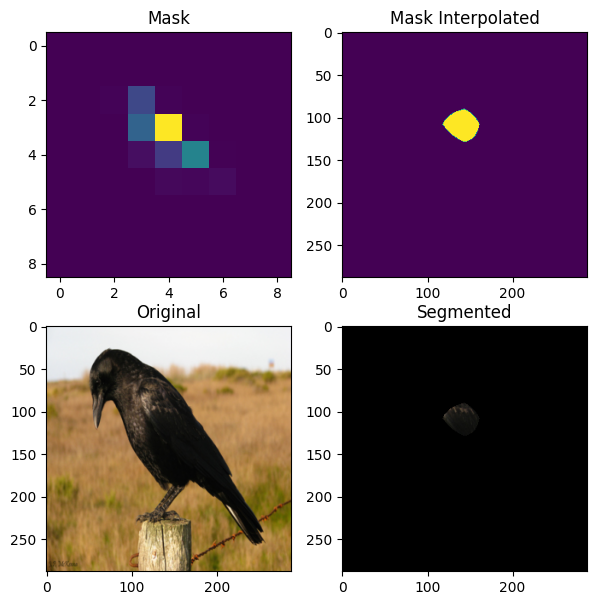

In [ ]:
viz_kth_best(0)

idx=19
torch.return_types.sort(
values=tensor([ 1.0000e+00,  6.8355e-01,  6.4185e-01,  5.5031e-01,  4.8658e-01,
         4.3426e-01,  3.9466e-01,  3.7344e-01,  3.6388e-01,  3.5337e-01,
         3.3114e-01,  3.0051e-01,  2.9611e-01,  2.9237e-01,  2.8687e-01,
         2.8602e-01,  2.8495e-01,  2.7905e-01,  2.7304e-01,  2.6088e-01,
         2.5498e-01,  2.5178e-01,  2.4509e-01,  2.4473e-01,  2.3972e-01,
         2.2929e-01,  2.2815e-01,  2.2469e-01,  2.2421e-01,  2.2230e-01,
         2.1636e-01,  2.1596e-01,  2.1199e-01,  2.0267e-01,  2.0236e-01,
         1.9586e-01,  1.8980e-01,  1.8702e-01,  1.8559e-01,  1.8481e-01,
         1.8460e-01,  1.7783e-01,  1.7706e-01,  1.7092e-01,  1.6236e-01,
         1.6154e-01,  1.6056e-01,  1.5890e-01,  1.5626e-01,  1.5578e-01,
         1.5246e-01,  1.5246e-01,  1.5117e-01,  1.5097e-01,  1.4836e-01,
         1.4618e-01,  1.4562e-01,  1.4519e-01,  1.4219e-01,  1.4129e-01,
         1.3820e-01,  1.3453e-01,  1.3018e-01,  1.2771e-01,  1.2653e-01,
         1.2

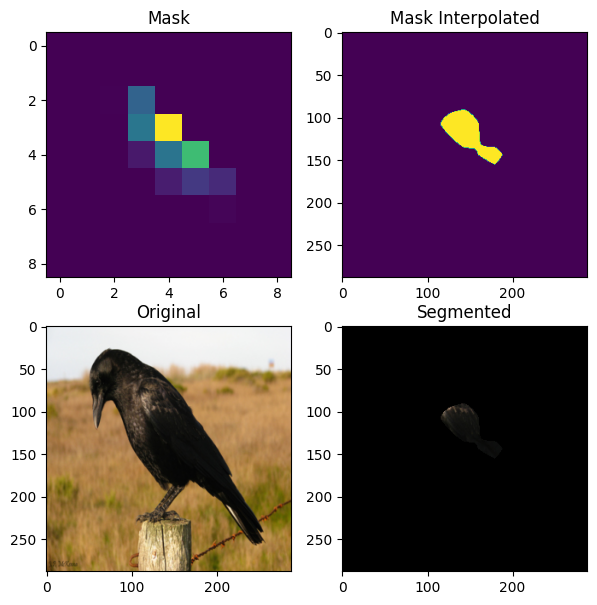

In [ ]:
viz_kth_best(1)

idx=57
torch.return_types.sort(
values=tensor([ 1.0000e+00,  5.5969e-01,  5.3030e-01,  5.2662e-01,  5.1062e-01,
         4.1365e-01,  3.5476e-01,  3.4395e-01,  3.2471e-01,  3.2211e-01,
         3.2171e-01,  2.9282e-01,  2.9129e-01,  2.9065e-01,  2.9044e-01,
         2.8860e-01,  2.8502e-01,  2.7424e-01,  2.6593e-01,  2.6541e-01,
         2.5892e-01,  2.5593e-01,  2.5547e-01,  2.4123e-01,  2.3924e-01,
         2.1752e-01,  2.1650e-01,  2.0967e-01,  2.0769e-01,  2.0754e-01,
         2.0598e-01,  2.0420e-01,  2.0279e-01,  2.0269e-01,  2.0218e-01,
         2.0180e-01,  2.0169e-01,  1.9900e-01,  1.9893e-01,  1.9654e-01,
         1.9604e-01,  1.9586e-01,  1.9576e-01,  1.9523e-01,  1.9499e-01,
         1.9140e-01,  1.8927e-01,  1.8858e-01,  1.8552e-01,  1.8186e-01,
         1.8091e-01,  1.7653e-01,  1.7611e-01,  1.7576e-01,  1.7543e-01,
         1.7411e-01,  1.7404e-01,  1.6441e-01,  1.6044e-01,  1.5896e-01,
         1.5520e-01,  1.5222e-01,  1.5043e-01,  1.4654e-01,  1.4639e-01,
         1.4

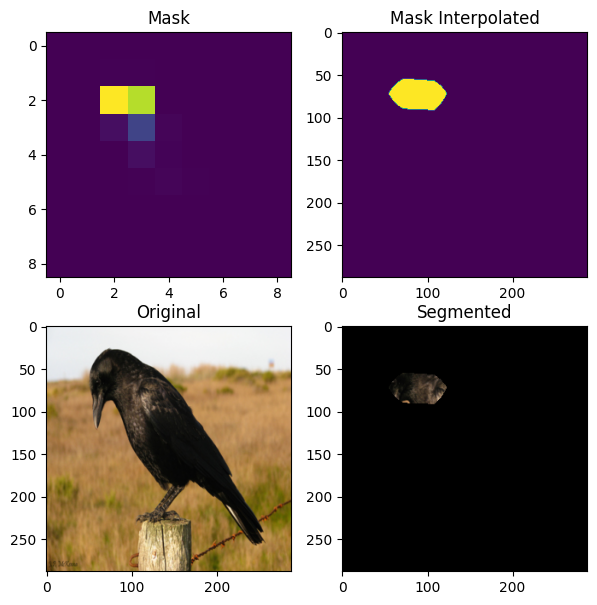

In [ ]:
viz_kth_best(2)